<a href="https://colab.research.google.com/github/nestorbalcazar/nestorbalcazar.github.io/blob/master/NumMethods_ConductionConcentricSpheres1D_Steady_Ex00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[FVM shell] N=200: iters=152669, Tmin=349.397, Tmax=358.072
N=200 | L_inf = 3.359e-04 K | L2 = 2.255e-04 K
T(R1) num≈? (reconstruct below), T(R1) anal = 349.285714 K
T(R2) num≈? (reconstruct below), T(R2) anal = 350.684524 K

Energy balance:
  Q_gen      = 1.832596e+03 W
  Q_in_num   = 5.587534e+02 W
  Q_out_num  = 1.273842e+03 W
  Rel. error balance = 7.728e-11
  Q_in_exact  = 5.587547e+02 W
  Q_out_exact = 1.273841e+03 W
  Rel. error exact  = 2.481e-16

Reconstructed T(R1) num = 349.285578 K  | analytical = 349.285714 K  | diff = 1.360e-04 K
Reconstructed T(R2) num = 350.684575 K  | analytical = 350.684524 K  | diff = 5.101e-05 K


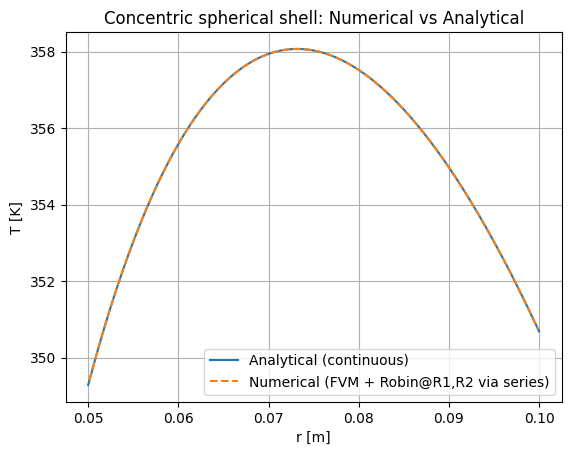

In [3]:
#=======================================================================================
# Numerical Methods in Heat and Mass Transfer
#=======================================================================================
# Support material for Lecture Notes. Prof. Néstor Balcázar-Arciniega
# Updated: 7 October 2025
# --- Concentric spherical shell: radial 1D conduction (steady), FVM + GS/SOR ---
# PDE (steady, λ and qdot constants over R1<=r<=R2):
#   (1/r^2) d/dr ( r^2 λ dT/dr ) + qdot = 0
# BCs:
#   r = R1 (inner surface):  λ dT/dr|_{R1}   = α_A (T(R1) - T_A)   [outward normal points inward]
#   r = R2 (outer surface): -λ dT/dr|_{R2}   = α_B (T(R2) - T_B)
# Discretization: Finite Volume Method (centroid-to-centroid distances).
# Robin BCs enforced via series-resistance coefficients:
#   Fw = A_in / ( 1/α_A + Δr_in/λ ), with Δr_in = (r_P1 - R1)
#   Fe = A_out/ ( 1/α_B + Δr_out/λ), with Δr_out = (R2   - r_PN)
# where A_in = 4π R1^2, A_out = 4π R2^2.

import numpy as np
import matplotlib.pyplot as plt

# -------- Physical parameters --------
R1      = 0.05        # [m] inner radius
R2      = 0.10        # [m] outer radius
lam     = 20.0        # [W/(m·K)] thermal conductivity (constant)
qdot    = 5.0e5       # [W/m^3] volumetric heat generation (constant, in the solid R1..R2)
alpha_A = 300.0       # [W/(m^2·K)] inner convection coefficient
T_A     = 290.0       # [K] inner fluid temperature
alpha_B = 200.0       # [W/(m^2·K)] outer convection coefficient
T_B     = 300.0       # [K] outer fluid temperature

A_in  = 4.0*np.pi*R1**2
A_out = 4.0*np.pi*R2**2

# -------- Analytical solution (true Robin at both surfaces) --------
# General solution of (1/r^2)d/dr(r^2 dT/dr) = -qdot/lam:
#   T(r) = - (qdot/(6*lam)) r^2 + C1 + C2/r
# Apply BCs:
#   at r=R1:  λ dT/dr = α_A (T - T_A)
#   at r=R2: -λ dT/dr = α_B (T - T_B)
def analytical_profile(r):
    # Build linear system for C1, C2
    # dT/dr = - (qdot/(3*lam)) r - C2/r^2
    # R1 BC: λ dT/dr|R1 = - (qdot/3) R1 - λ C2 / R1**2 = α_A (T(R1) - T_A)
    # R2 BC: -λ dT/dr|R2 =  (qdot/3) R2 + λ C2 / R2**2 = α_B (T(R2) - T_B)
    # T(R) = - (qdot/(6*lam)) R^2 + C1 + C2/R
    # Solve for C1, C2.
    # We'll assemble two linear equations in C1, C2:

    # Coeffs for inner BC:
    # α_A*(T(R1)-T_A) + (qdot/3)R1 + λ C2/R1^2 = 0  (moved all to LHS)
    # => α_A*( -qdot/(6lam) R1^2 + C1 + C2/R1 - T_A ) + (qdot/3)R1 + λ C2/R1^2 = 0
    A11 = alpha_A * 1.0                              # multiplies C1
    A12 = alpha_A*(1.0/R1) + lam*(1.0/(R1**2))       # multiplies C2
    b1  = alpha_A*( (qdot/(6.0*lam))*(R1**2) + T_A ) - (qdot/3.0)*R1

    # Coeffs for outer BC:
    # α_B*(T(R2)-T_B) - (qdot/3)R2 - λ C2/R2^2 = 0  (since (qdot/3)R2 + λC2/R2^2 = α_B(T-T_B))
    # => α_B*( -qdot/(6lam) R2^2 + C1 + C2/R2 - T_B ) - (qdot/3)R2 - λ C2/R2^2 = 0
    A21 = alpha_B * 1.0
    A22 = alpha_B*(1.0/R2) - lam*(1.0/(R2**2))
    b2  = alpha_B*( (qdot/(6.0*lam))*(R2**2) + T_B ) + (qdot/3.0)*R2

    # Solve [A]{C} = {b}
    A = np.array([[A11, A12],
                  [A21, A22]], dtype=float)
    b = np.array([b1, b2], dtype=float)
    C1, C2 = np.linalg.solve(A, b)

    return - (qdot/(6.0*lam))*r**2 + C1 + C2/r

# -------- FVM assembly + GS/SOR (Robin via Fe on both sides) --------
def solve_fvm_spherical_shell(N, omega=1.7, tol=1e-12, itmax=200000, verbose=False):
    """
    Builds and solves the 1D radial FVM system in a concentric spherical shell with
    Robin BCs at r=R1 (inner) and r=R2 (outer), enforced via series-resistance
    coefficients Fw and Fe. Distances are centroid-to-centroid; face areas at faces.
    """
    # Mesh (faces and centroids) over [R1, R2]
    r_f = np.linspace(R1, R2, N+1)                 # face radii
    r_c = 0.5*(r_f[:-1] + r_f[1:])                 # cell centroids

    # Geometric factors
    Aw  = 4.0*np.pi*(r_f[:-1]**2)                  # west-face area for cell i (r_f[i])
    Ae  = 4.0*np.pi*(r_f[1:]**2)                   # east-face area  for cell i (r_f[i+1])
    Vp  = (4.0*np.pi/3.0)*(r_f[1:]**3 - r_f[:-1]**3)

    # Centroid-to-centroid distances
    dWP = np.zeros(N); dPE = np.zeros(N)
    dWP[1:]  = r_c[1:] - r_c[:-1]                  # r_P - r_W
    dPE[:-1] = r_c[1:] - r_c[:-1]                  # r_E - r_P

    # Linear system aP*T_P = aE*T_E + aW*T_W + bP
    aW = np.zeros(N); aE = np.zeros(N); aP = np.zeros(N); bP = np.zeros(N)
    SU = qdot * Vp                                  # S_U = qdot * Vp (heating)

    for i in range(N):
        # West conductance (centroid-to-centroid)
        Dw = 0.0 if i == 0 else lam * Aw[i] / (dWP[i] + 1e-300)
        # East conductance (centroid-to-centroid)
        De = 0.0 if i == N-1 else lam * Ae[i] / (dPE[i] + 1e-300)

        aW[i] = Dw
        aE[i] = De
        aP[i] = Dw + De
        bP[i] = SU[i]

        # Inner Robin via series resistance (first cell)
        if i == 0:
            delta_in = r_c[0] - R1
            Fw = A_in / ( (1.0/alpha_A) + (delta_in/(lam + 1e-300)) )
            aP[i] += Fw
            bP[i] += Fw * T_A

        # Outer Robin via series resistance (last cell)
        if i == N-1:
            delta_out = R2 - r_c[-1]
            Fe = A_out / ( (1.0/alpha_B) + (delta_out/(lam + 1e-300)) )
            aP[i] += Fe
            bP[i] += Fe * T_B

    # Gauss–Seidel / SOR
    def gauss_seidel(aW, aP, aE, bP, T0, omega, tol, itmax):
        T = T0.copy()
        for it in range(itmax):
            Told = T.copy()
            for j in range(N):
                TW = T[j-1] if j > 0   else 0.0
                TE = T[j+1] if j < N-1 else 0.0
                RHS = aE[j]*TE + aW[j]*TW + bP[j]
                T[j] = (1.0-omega)*T[j] + omega * RHS / (aP[j] + 1e-300)
            if np.max(np.abs(T - Told)) < tol:
                return T, it+1
        return T, itmax

    T0 = np.full(N, 0.5*(T_A+T_B))  # reasonable initial guess
    Tn, iters = gauss_seidel(aW, aP, aE, bP, T0, omega, tol, itmax)
    if verbose:
        print(f"[FVM shell] N={N}: iters={iters}, Tmin={Tn.min():.3f}, Tmax={Tn.max():.3f}")
    return r_c, r_f, Tn, iters

# -------- Run one mesh and compare --------
N = 200
r_c, r_f, T_num, iters = solve_fvm_spherical_shell(N, omega=1.7, tol=1e-12, itmax=200000, verbose=True)

# Analytical profile (centers and surfaces)
T_ref_c = analytical_profile(r_c)
T_R1    = analytical_profile(R1)
T_R2    = analytical_profile(R2)

# Errors at cell centers
Linf = np.max(np.abs(T_num - T_ref_c))
L2   = np.sqrt(np.mean((T_num - T_ref_c)**2))
print(f"N={N} | L_inf = {Linf:.3e} K | L2 = {L2:.3e} K")
print(f"T(R1) num≈? (reconstruct below), T(R1) anal = {T_R1:.6f} K")
print(f"T(R2) num≈? (reconstruct below), T(R2) anal = {T_R2:.6f} K")

# --- Energy balance (global) ---
V_shell = (4.0*np.pi/3.0)*(R2**3 - R1**3)
Q_gen   = qdot * V_shell
# Discrete boundary heat leaves through both surfaces:
delta_in  = r_c[0]  - R1
delta_out = R2      - r_c[-1]
Fw_last   = A_in  / ( (1.0/alpha_A) + (delta_in /(lam + 1e-300)) )
Fe_last   = A_out / ( (1.0/alpha_B) + (delta_out/(lam + 1e-300)) )
Q_in_num  = Fw_last * (T_num[0]  - T_A)  # heat to inner fluid
Q_out_num = Fe_last * (T_num[-1] - T_B)  # heat to outer fluid
print("\nEnergy balance:")
print(f"  Q_gen      = {Q_gen:.6e} W")
print(f"  Q_in_num   = {Q_in_num:.6e} W")
print(f"  Q_out_num  = {Q_out_num:.6e} W")
print(f"  Rel. error balance = {abs(Q_gen - (Q_in_num + Q_out_num))/abs(Q_gen):.3e}")

# Also exact convection using analytical surface temperatures:
Q_in_exact  = alpha_A * A_in  * (T_R1 - T_A)
Q_out_exact = alpha_B * A_out * (T_R2 - T_B)
print(f"  Q_in_exact  = {Q_in_exact:.6e} W")
print(f"  Q_out_exact = {Q_out_exact:.6e} W")
print(f"  Rel. error exact  = {abs(Q_gen - (Q_in_exact + Q_out_exact))/abs(Q_gen):.3e}")

# --- Optional: reconstruct surface temperatures from discrete fluxes (consistency) ---
T_R1_num = T_A + Q_in_num  / (alpha_A * A_in)
T_R2_num = T_B + Q_out_num / (alpha_B * A_out)
print(f"\nReconstructed T(R1) num = {T_R1_num:.6f} K  | analytical = {T_R1:.6f} K  | diff = {abs(T_R1_num-T_R1):.3e} K")
print(f"Reconstructed T(R2) num = {T_R2_num:.6f} K  | analytical = {T_R2:.6f} K  | diff = {abs(T_R2_num-T_R2):.3e} K")

# -------- Plot: analytical vs numerical --------
r_plot = np.linspace(R1, R2, 400)
plt.figure()
plt.plot(r_plot, analytical_profile(r_plot), '-', label='Analytical (continuous)')
plt.plot(r_c, T_num, '--', label='Numerical (FVM + Robin@R1,R2 via series)')
plt.xlabel('r [m]'); plt.ylabel('T [K]')
plt.title('Concentric spherical shell: Numerical vs Analytical')
plt.grid(True); plt.legend()
plt.show()
